In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as pdr
from datetime import datetime as dt

import tensorflow as tf
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

In [2]:
# Load data for specific company
company = 'FB'  # using facebook as an example

start = dt(2012, 1, 1)
end = dt(2020, 8, 1)

training_data = pdr.DataReader(company, 'yahoo', start, end)
validation_data = pdr.DataReader(company, 'yahoo', end, dt(dt.now().year, dt.now().month, dt.now().day))

In [3]:
training_data.head()  # we want to predict the values in the Close column, based on preceding Close column entries

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-05-18,45.000000,38.000000,42.049999,38.230000,573576400,38.230000
2012-05-21,36.660000,33.000000,36.529999,34.029999,168192700,34.029999
2012-05-22,33.590000,30.940001,32.610001,31.000000,101786600,31.000000
2012-05-23,32.500000,31.360001,31.370001,32.000000,73600000,32.000000
2012-05-24,33.209999,31.770000,32.950001,33.029999,50237200,33.029999


In [4]:
# Scale data to range between [0,1]
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(training_data['Close'].values.reshape(-1,1))  # before scaling, reshape the closing values array into a single column vector

In [5]:
prediction_days = 60  # number of days of data to use for making prediction

X, Y = [], []

for x in range(prediction_days, len(scaled_data)):
    X.append(scaled_data[x - prediction_days:x])  # prediction_days values before x is the input 
    Y.append(scaled_data[x, 0])  # the single value after prediction_days values, x, is the output (,0 is to flatten)

# Convert to numpy arrays
X, Y = np.array(X), np.array(Y)

In [6]:
print(X.shape, Y.shape)

(2004, 60, 1) (2004,)


In [7]:
# Save the last 100 data pairs for validation
x_train, y_train, x_valid, y_valid = X[:X.shape[0]-100], Y[:Y.shape[0]-100], X[X.shape[0]-100:], Y[Y.shape[0]-100:]

In [8]:
print(x_train[0])
print("-----------")
print(y_train[0])

[[0.0868865 ]
 [0.06908536]
 [0.05624311]
 [0.06048148]
 [0.06484699]
 [0.06010003]
 [0.04708825]
 [0.04433331]
 [0.0503094 ]
 [0.04234127]
 [0.03886581]
 [0.0345003 ]
 [0.03848436]
 [0.03636518]
 [0.03971349]
 [0.03933204]
 [0.040985  ]
 [0.04043401]
 [0.04475715]
 [0.05204713]
 [0.05798084]
 [0.06010003]
 [0.05878614]
 [0.05980334]
 [0.06493176]
 [0.06073579]
 [0.06514368]
 [0.0614563 ]
 [0.05776893]
 [0.05666695]
 [0.05526829]
 [0.05709079]
 [0.05823514]
 [0.05933712]
 [0.061202  ]
 [0.05823514]
 [0.05611596]
 [0.05543782]
 [0.05505637]
 [0.04458761]
 [0.04390947]
 [0.04823261]
 [0.04776638]
 [0.04674918]
 [0.04670679]
 [0.04543529]
 [0.04920743]
 [0.0386539 ]
 [0.02534543]
 [0.02297194]
 [0.01686869]
 [0.01335085]
 [0.00979063]
 [0.01424091]
 [0.01775875]
 [0.01267271]
 [0.01267271]
 [0.01390184]
 [0.01729253]
 [0.01640248]]
-----------
0.011231667516973048


In [9]:
# Building the RNN model
model = tf.keras.Sequential([
    layers.LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)), # return_sequences determines if output is flat or is a sequence
    layers.Dropout(0.2),
    layers.LSTM(50, return_sequences=True),
    layers.Dropout(0.2),
    layers.LSTM(50, return_sequences=False),
    layers.Dropout(0.2),

    layers.Dense(25),
    layers.Dense(1)  # predicition layer
])

In [10]:
# opt = keras.optimizers.Adam(lr=1e-3, decay=1e-5)
model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mean_absolute_error']
)

In [11]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_mean_absolute_error',
    min_delta=0.001,
    verbose=1,
    patience=25,
    restore_best_weights=True
)

In [12]:
history = model.fit(
    x_train, y_train,
    validation_data=(x_train, y_train),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/100
60/60 [==============================] - 8s 70ms/step - loss: 0.0332 - mean_absolute_error: 0.1212 - val_loss: 6.7884e-04 - val_mean_absolute_error: 0.0192
Epoch 2/100
60/60 [==============================] - 3s 52ms/step - loss: 0.0029 - mean_absolute_error: 0.0392 - val_loss: 7.5504e-04 - val_mean_absolute_error: 0.0199
Epoch 3/100
60/60 [==============================] - 3s 52ms/step - loss: 0.0027 - mean_absolute_error: 0.0371 - val_loss: 9.2596e-04 - val_mean_absolute_error: 0.0223
Epoch 4/100
60/60 [==============================] - 3s 53ms/step - loss: 0.0021 - mean_absolute_error: 0.0324 - val_loss: 5.9855e-04 - val_mean_absolute_error: 0.0173
Epoch 5/100
60/60 [==============================] - 3s 53ms/step - loss: 0.0018 - mean_absolute_error: 0.0301 - val_loss: 8.3991e-04 - val_mean_absolute_error: 0.0216
Epoch 6/100
60/60 [==============================] - 3s 52ms/step - loss: 0.0018 - mean_absolute_error: 0.0298 - val_loss: 8.4876e-04 - val_mean_absolute_error:

<AxesSubplot:>

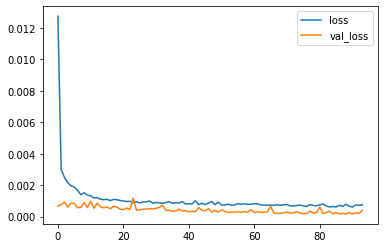

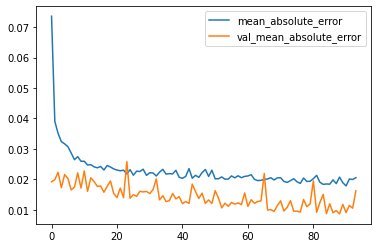

In [13]:
# Plot training history
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['mean_absolute_error', 'val_mean_absolute_error']].plot()

<AxesSubplot:>

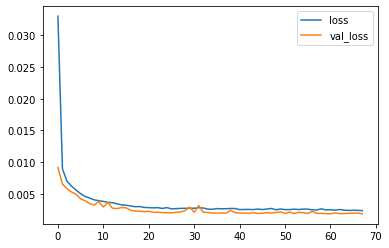

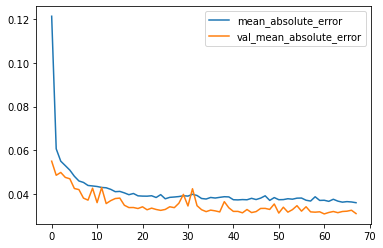

In [13]:
# model with last LSTM layer return_sequence=True
# Plot training history
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['mean_absolute_error', 'val_mean_absolute_error']].plot()

In [14]:
# Making predictions on unused validation data
actual_prices = validation_data['Close'].values

total_dataset = pd.concat((training_data['Close'], validation_data['Close']), axis=0)
total_dataset.head()

Date
2012-05-18    38.230000
2012-05-21    34.029999
2012-05-22    31.000000
2012-05-23    32.000000
2012-05-24    33.029999
Name: Close, dtype: float64

In [18]:
model_inputs = total_dataset[len(total_dataset) - len(validation_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.transform(model_inputs)

x_validation = []

for x in range(prediction_days, len(model_inputs)):
    x_validation.append(model_inputs[x-prediction_days:x])

x_validation = np.array(x_validation)

(252, 60, 1)